<a href="https://colab.research.google.com/github/NiallJeffrey/MomentNetworks/blob/master/notebooks_testB/moment_network_scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Make network estimate 2 parameter mean, variance and covariance as a function of numer of training data

# Load modules

In [1]:
!pip install emcee getdist

     |████████████████████████████████| 51kB 2.1MB/s 
     |████████████████████████████████| 747kB 8.1MB/s 
  Created wheel for getdist: filename=GetDist-1.1.2-cp36-none-any.whl size=197663 sha256=1c7cbd2d5ae0ceda2ab3dc4fff3f94a528a39c3a393a13a382971708bead0f06
  Stored in directory: /root/.cache/pip/wheels/3f/b5/8a/e3d4221e66472ed329545d7026cec59dfd379256ca42692877
Successfully built getdist


In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy import fftpack

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Input
from tensorflow.keras.layers import concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

In [3]:
import os, sys
import random
import emcee as mc
import getdist
from getdist import plots, MCSamples
import scipy.interpolate as interpolate
import time
%matplotlib inline

In [4]:
n_training = 200000
size=12
cov_signal_fourier = np.identity(size)*np.logspace(size,size*0.9,size)/np.sum(np.logspace(size,size*0.9,size))
# cov_signal_fourier = np.identity(size)*np.logspace(size,size*0.9,size)/np.sum(np.logspace(size,size*0.9,size))
cov_noise = np.identity(size)*4
cov_noise_inv = np.linalg.pinv(cov_noise)

0.7275716840068773


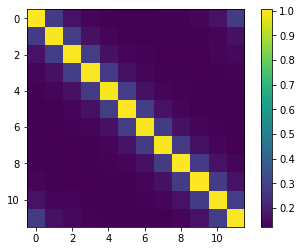

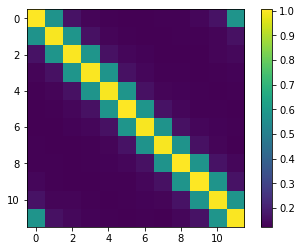

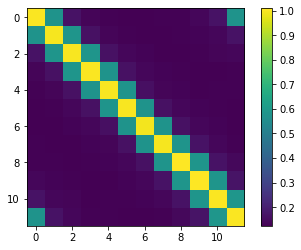

(<matplotlib.image.AxesImage at 0x7f8c0d19f3c8>,
 None)

In [5]:
training_z = np.random.multivariate_normal(np.zeros(size),cov_signal_fourier,n_training) + \
                  1j*np.random.multivariate_normal(np.zeros(size), cov_signal_fourier,n_training)
training_z = np.fft.fft(training_z).real

cov_signal = np.identity(size)*0.


mean_z = np.mean(training_z,axis=0)

for i in range(n_training-1):
  cov_signal += np.outer(training_z[i] - mean_z,training_z[i]-mean_z) 

cov_signal = cov_signal/np.float(n_training-1.)

print(cov_signal[0,0]-cov_signal[0,1])
plt.imshow(cov_signal), plt.colorbar(), plt.show()
cov_signal_new = np.where((cov_signal<0.9)&(cov_signal>0.2),cov_signal+0.3,cov_signal)
# cov_signal_new = cov_signal + 1.5*(cov_signal[0,0]-cov_signal[0,1])*(np.eye(size, size, 1) + np.eye(size, size, -1))
plt.imshow(cov_signal_new), plt.colorbar(), plt.show()
training_z = np.random.multivariate_normal(np.zeros(size),cov_signal_new,n_training)

cov_signal = np.identity(size)*0.

for i in range(n_training-1):
  cov_signal += np.outer(training_z[i] - mean_z,training_z[i]-mean_z) 

cov_signal = cov_signal/np.float(n_training-1.)

cov_signal_inv = np.linalg.pinv(cov_signal)

plt.imshow(cov_signal), plt.colorbar(), plt.show()


In [6]:
np.max(cov_signal)

1.009883919372303

In [7]:
training_data = training_z +  np.random.multivariate_normal(np.zeros(size),cov_noise,n_training)


# training_z_obs = [0.4215805176002967,0.6393815145750068,0.8849377727220539,0.6077305417307434,-0.8531217838033294,-0.12225528798358831,1.607681112774093,-0.8346558459419131,-0.8234095417545579,-0.08837119382949177,-0.41932094038118506,-1.1017438321572854,-0.030931945021035245,0.8875949892513813,2.5907557597830264,0.618930412473951,0.29507041051959826,0.7800988483845521,1.1114699937977721,1.0999993884249963]
# training_data_obs = [0.06688354292573245,0.11009484176188034,0.693983815382165,0.4989298235882621,-1.0302664780894921,-0.3514696496383829,2.203795259852168,-0.6686389561702446,-1.04247753503396,0.23912911295277722,-0.05471705344253447,-0.8261390558604902,-0.09118502863604327,0.6288049299266316,2.670024954560787,0.842413488578387,0.34754753025025376,1.0929090324213837,1.300615137425332,0.89671055886374]
training_z_obs = training_z[0]
training_data_obs = training_data[0]
training_z = training_z[1:]
training_data = training_data[1:]

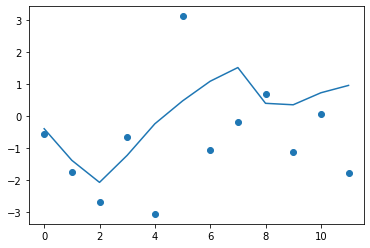

In [8]:
plt.plot(training_z_obs)
plt.scatter(np.arange(size),training_data_obs)

# Do MCMC

In [9]:
def log_prior(theta, data,cov_signal_inv):
    return -0.5*np.inner(theta,np.inner(cov_signal_inv,theta))

def log_likelihood(theta, data,cov_noise_inv):
    return -0.5*np.inner(theta-data,np.inner(cov_noise_inv,theta-data))

def log_posterior_delfi(theta, data,cov_signal_inv):
    return log_prior(theta, data,cov_signal_inv) + DelfiEnsemble.log_likelihood_stacked(theta,data=data) 

def log_posterior_likelihood(theta, data,cov_signal_inv,cov_noise_inv):
    return log_prior(theta, data,cov_signal_inv)  + log_likelihood(theta, data,cov_noise_inv)


In [10]:
def initial_parameters(theta, relative_sigma):
    """
    This is not randomise the initial position of the
    :param theta: list/array of parameter values
    :param relative_sigma: controls variance of random draws
    :return: the theta array but with random shifts
    """
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))

In [11]:
n_dim=size
n_burn=5000
n_steps = 50000
n_walkers = 2 * n_dim



sampler_likelihood = mc.EnsembleSampler(n_walkers, n_dim, log_posterior_likelihood,
                             args=(training_data_obs,cov_signal_inv,cov_noise_inv,))

In [12]:
theta_expected_mean = [0.1]*size

theta0 = np.array([list(initial_parameters(theta_expected_mean, 1)) for i in range(n_walkers)])

In [13]:
t = time.time()
_ =sampler_likelihood.run_mcmc(theta0, n_steps) 

print(time.time() - t)

flat_samples_likelihood = sampler_likelihood.get_chain(discard=n_burn, flat=True)
# print(flat_samples_likelihood.shape)
# flat_samples_likelihood[:,1] = flat_samples_likelihood[:,1]-flat_samples_likelihood[:,0]*0.1

43.532845973968506


In [14]:
n_samples = flat_samples_likelihood.shape[0]

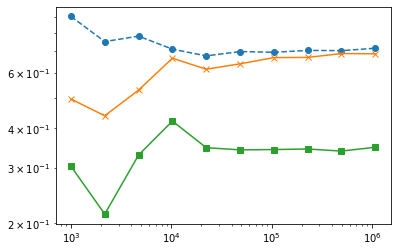

In [15]:
intervals = np.logspace(3,np.log10(n_samples), 10, dtype=int)
var_0 = []
var_1 = []
cov_01 = []
for sub_sample in intervals:
  covar = np.cov(flat_samples_likelihood[:sub_sample,0],flat_samples_likelihood[:sub_sample,1])
  var_0.append(covar[0,0])
  var_1.append(covar[1,1])
  cov_01.append(covar[0,1])
_ = plt.plot(intervals, var_0, 'o--')
_ = plt.plot(intervals, var_1, marker='x')
_ = plt.plot(intervals, cov_01, marker='s')
_ = plt.xscale('log'), plt.yscale('log')

Removed no burn in


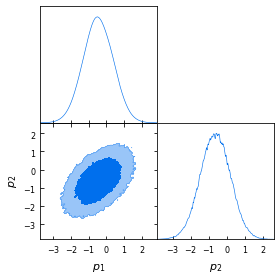

In [16]:
samples2 = MCSamples(samples=flat_samples_likelihood[:,:2],label='lik')

g = plots.get_subplot_plotter()
g.triangle_plot([samples2], filled=True)

In [17]:
np.cov(flat_samples_likelihood[:,0],flat_samples_likelihood[:,1])

array([[0.7160372 , 0.34830443],
       [0.34830443, 0.6874745 ]])

# Moment network

In [18]:
class simple_leaky:
    """
    A simple MLP with LeakyReLU activation
    """
    
    def __init__(self, input_size, output_size, learning_rate=None):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.output_size = output_size
        
    def model(self):
        print(self.input_size)
        
        input_data = (Input(shape=(self.input_size,)))

        x1 = Dense(100, input_dim=self.input_size, kernel_initializer='normal')(input_data)
        x1 = LeakyReLU(alpha=0.1)(x1)
        x2 = Dense(150, kernel_initializer='normal')(x1)
        x2 = LeakyReLU(alpha=0.1)(x2)
        x3 = Dense(100, kernel_initializer='normal')(x2)
        x3 = LeakyReLU(alpha=0.1)(x3)
        x4 = Dense(self.output_size, kernel_initializer='normal')(x3)
        

        dense_model = Model(input_data, x4)
        dense_model.summary()

        if self.learning_rate is None:
            dense_model.compile(optimizer='adam', loss='mse')
        else:
            dense_model.compile(optimizer=optimizers.Adam(lr=self.learning_rate), loss='mse')

        return dense_model

In [19]:
model_instance = simple_leaky(size,2, learning_rate=1e-4)
regression = model_instance.model()

12
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1300      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               15150     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 100)           

In [20]:
history = regression.fit(training_data[:80000],
                               training_z[:80000,:2],
                               epochs =20,batch_size =50, shuffle=True,
                               validation_data = (training_data[80000:],
                               training_z[80000:,:2]))

Epoch 1/20
1600/1600 [==============================] - 7s 5ms/step - loss: 0.7381 - val_loss: 0.7080
Epoch 2/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7126 - val_loss: 0.7077
Epoch 3/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7117 - val_loss: 0.7072
Epoch 4/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7108 - val_loss: 0.7068
Epoch 5/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7104 - val_loss: 0.7083
Epoch 6/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7100 - val_loss: 0.7072
Epoch 7/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7096 - val_loss: 0.7073
Epoch 8/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7094 - val_loss: 0.7071
Epoch 9/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.7089 - val_loss: 0.7081
Epoch 10/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.708

In [36]:
predicted_mean = regression.predict(np.atleast_2d(training_data))
predicted_mean_obs = regression.predict(np.atleast_2d(training_data_obs))

In [22]:
training_var_unknown_mean = (training_z[:,:2]-regression.predict(np.atleast_2d(training_data)))**2.
training_var_unknown_mean = np.hstack([training_var_unknown_mean,
                                      np.atleast_2d((training_z[:,0]-regression.predict(np.atleast_2d(training_data))[:,0])*
                                      (training_z[:,1]-regression.predict(np.atleast_2d(training_data))[:,1])).T])
training_var_unknown_mean.shape

(199999, 3)

In [23]:
model_instance = simple_leaky(size,3, learning_rate=1e-4)
regression_var_unknown_mean = model_instance.model()

12
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1300      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 150)               15150     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 150)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               15100     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 100)           

In [24]:
history = regression_var_unknown_mean.fit(training_data[:80000],
                               training_var_unknown_mean[:80000,:3],
                               epochs =20,batch_size =50, shuffle=True,
                               validation_data = (training_data[80000:],
                               training_var_unknown_mean[80000:,:3]))

Epoch 1/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8914 - val_loss: 0.8849
Epoch 2/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8718 - val_loss: 0.8819
Epoch 3/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8689 - val_loss: 0.8797
Epoch 4/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8669 - val_loss: 0.8789
Epoch 5/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8658 - val_loss: 0.8778
Epoch 6/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8650 - val_loss: 0.8787
Epoch 7/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8643 - val_loss: 0.8779
Epoch 8/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8638 - val_loss: 0.8796
Epoch 9/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.8637 - val_loss: 0.8781
Epoch 10/20
1600/1600 [==============================] - 7s 4ms/step - loss: 0.863

In [25]:
predicted_var_obs = (regression_var_unknown_mean.predict(np.atleast_2d(training_data_obs[:]))[0])
print(predicted_var_obs)

[0.64855975 0.6578776  0.3285656 ]


In [28]:
likelihood_param_cov = np.cov(flat_samples_likelihood[:,0],flat_samples_likelihood[:,1])

In [29]:
moment_network_param_cov = np.copy(likelihood_param_cov)
moment_network_param_cov[0,0] = predicted_var_obs[0]
moment_network_param_cov[1,1] = predicted_var_obs[1]
moment_network_param_cov[0,1] = predicted_var_obs[2]
moment_network_param_cov[1,0] = predicted_var_obs[2]

In [40]:
moment_network_samples = np.random.multivariate_normal(predicted_mean_obs[0],moment_network_param_cov,10000)

Removed no burn in
Removed no burn in


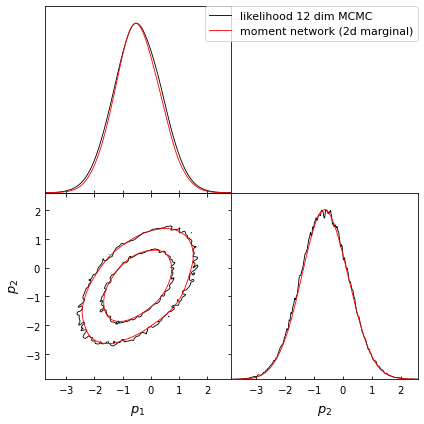

In [51]:
samples2 = MCSamples(samples=flat_samples_likelihood[:,:2],label='likelihood 12 dim MCMC')
samples_moment = MCSamples(samples=moment_network_samples,label='moment network (2d marginal)')

g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples2, samples_moment], filled=False )

In [1]:
print(5)

5
